# CS715 Final Exam Part I

### Aim : Predict the close price from S&P/TSX Composite Index which is the benchmark Canadian index of the Toronto Stock Exchange. 

Model : Long-Short Term Memory 

The project consists of two models<br>
a) Predict Stock Price for Tomorrow<br>
b) Predict Stock Price for next 10 days(Multi-step LSTM)

### 1. Predict Stock Price for next day

#### 1.1 Libraries & data Import

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
data = pd.read_csv('GSPTSE.csv', header = 0)

In [6]:
data.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-21,17367.000000,17507.699219,17307.500000,17500.900391,17500.900391,247287200
2020-12-22,17538.199219,17572.900391,17478.400391,17552.500000,17552.500000,208088700
2020-12-23,17586.900391,17652.699219,17583.599609,17593.599609,17593.599609,185161800
2020-12-24,17595.900391,17641.699219,17568.500000,17623.900391,17623.900391,95985400
2020-12-29,17610.500000,17661.199219,17512.199219,17543.400391,17543.400391,205406800
...,...,...,...,...,...,...
2022-12-12,19841.099609,20019.900391,19834.300781,20019.699219,20019.699219,305801700
2022-12-13,20312.900391,20341.300781,19955.599609,20023.500000,20023.500000,278272300
2022-12-14,20022.599609,20081.800781,19864.000000,19891.699219,19891.699219,263781200


In [7]:
print(data.shape)

(500, 7)


In [8]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02
mean,19981.845414,20071.245992,19878.450203,19978.096410,19978.096410,2.478760e+08
std,1124.576869,1123.717758,1127.229504,1122.197148,1122.197148,7.184025e+07
min,17367.000000,17507.699219,17297.800781,17337.000000,17337.000000,4.052060e+07
25%,19154.850098,19228.675293,19058.400391,19140.974610,19140.974610,2.082304e+08
50%,20120.649414,20204.599609,20017.800781,20144.650390,20144.650390,2.431928e+08
75%,20838.774902,20934.924317,20713.524902,20793.075196,20793.075196,2.721043e+08
max,22109.699219,22213.099609,22045.199219,22087.199219,22087.199219,6.397440e+08


#### 2.1 Plotting the stock prices


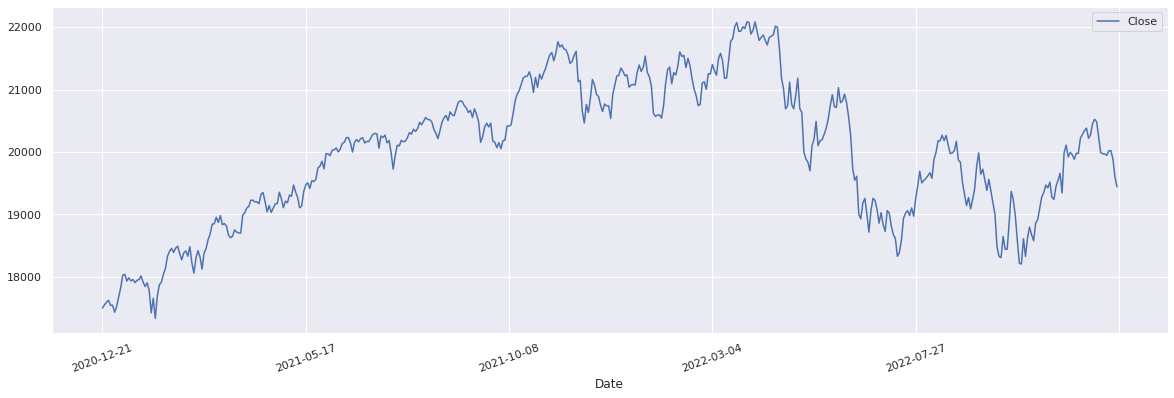

In [9]:
%matplotlib inline
data.plot(x='Date', y='Close', kind='line', figsize=(20,6), rot=20)

#### 3.1 Data Normalizing 
LSTM algorithm : Standardizing or normalizing the data is required for a fast and more accurate fit.


In [10]:
# Extracting the closing prices of each day
FullData=data[['Close']].values
print(FullData[0:5])

# Feature Scaling for fast training of neural networks
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
print('### After Normalization ###')
X[0:5]

[[17500.900391]
 [17552.5     ]
 [17593.599609]
 [17623.900391]
 [17543.400391]]
### After Normalization ###


array([[0.0345039 ],
       [0.04536652],
       [0.0540187 ],
       [0.06039755],
       [0.04345089]])

In [11]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

# Reshape the Input as a 3D (number of samples, Time Steps, Features) : To pass as valid input to network
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(490, 10, 1)

#### Output Data shape ####
(490, 1)


In [12]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(485, 10, 1)
(485, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [13]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [21]:
# Lines of Code for model
early_stopping = EarlyStopping()
regressor = Sequential()
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100, callbacks=[early_stopping])


Epoch 1/100
95/97 [============================>.] - ETA: 0s - loss: 0.1968

97/97 [==============================] - 6s 9ms/step - loss: 0.1929
Epoch 2/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0091

97/97 [==============================] - 1s 9ms/step - loss: 0.0089
Epoch 3/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0083

97/97 [==============================] - 1s 9ms/step - loss: 0.0083
Epoch 4/100
96/97 [============================>.] - ETA: 0s - loss: 0.0078

97/97 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.0076

97/97 [==============================] - 1s 9ms/step - loss: 0.0076
Epoch 6/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0069

97/97 [==============================] - 1s 9ms/step - loss: 0.0069
Epoch 7/100
96/97 [============================>.] - ETA: 0s - loss: 0.0075

97/97 [==============================] - 1s 8ms/step - loss: 0.0075
Epoch 8/100
95/97 [============================>.] - ETA: 0s - loss: 0.0064

97/97 [==============================] - 1s 9ms/step - loss: 0.0065
Epoch 9/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0063

97/97 [==============================] - 1s 9ms/step - loss: 0.0063
Epoch 10/100
95/97 [============================>.] - ETA: 0s - loss: 0.0058

97/97 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 11/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0051

97/97 [==============================] - 1s 9ms/step - loss: 0.0050
Epoch 12/100
94/97 [============================>.] - ETA: 0s - loss: 0.0049

97/97 [==============================] - 1s 9ms/step - loss: 0.0050
Epoch 13/100
94/97 [============================>.] - ETA: 0s - loss: 0.0051

97/97 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 14/100
97/97 [==============================] - ETA: 0s - loss: 0.0052

97/97 [==============================] - 1s 9ms/step - loss: 0.0052
Epoch 15/100
95/97 [============================>.] - ETA: 0s - loss: 0.0052

97/97 [==============================] - 1s 9ms/step - loss: 0.0052
Epoch 16/100
95/97 [============================>.] - ETA: 0s - loss: 0.0049

97/97 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 17/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0054

97/97 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 18/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0048

97/97 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 19/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0047

97/97 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 20/100
97/97 [==============================] - ETA: 0s - loss: 0.0054

97/97 [==============================] - 1s 9ms/step - loss: 0.0054
Epoch 21/100
96/97 [============================>.] - ETA: 0s - loss: 0.0045

97/97 [==============================] - 1s 8ms/step - loss: 0.0044
Epoch 22/100
96/97 [============================>.] - ETA: 0s - loss: 0.0044

97/97 [==============================] - 1s 9ms/step - loss: 0.0044
Epoch 23/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0042

97/97 [==============================] - 1s 8ms/step - loss: 0.0042
Epoch 24/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0047

97/97 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 25/100
96/97 [============================>.] - ETA: 0s - loss: 0.0042

97/97 [==============================] - 1s 9ms/step - loss: 0.0042
Epoch 26/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0041

97/97 [==============================] - 1s 9ms/step - loss: 0.0043
Epoch 27/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0042

97/97 [==============================] - 1s 9ms/step - loss: 0.0042
Epoch 28/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0040

97/97 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 29/100
96/97 [============================>.] - ETA: 0s - loss: 0.0039

97/97 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 30/100
95/97 [============================>.] - ETA: 0s - loss: 0.0039

97/97 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 31/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0039

97/97 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 32/100
97/97 [==============================] - ETA: 0s - loss: 0.0039

97/97 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 33/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0037

97/97 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 34/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0041

97/97 [==============================] - 1s 9ms/step - loss: 0.0041
Epoch 35/100
94/97 [============================>.] - ETA: 0s - loss: 0.0041

97/97 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 36/100
97/97 [==============================] - ETA: 0s - loss: 0.0035

97/97 [==============================] - 1s 9ms/step - loss: 0.0035
Epoch 37/100
95/97 [============================>.] - ETA: 0s - loss: 0.0035

97/97 [==============================] - 1s 9ms/step - loss: 0.0035
Epoch 38/100
95/97 [============================>.] - ETA: 0s - loss: 0.0036

97/97 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 39/100
96/97 [============================>.] - ETA: 0s - loss: 0.0037

97/97 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 40/100
94/97 [============================>.] - ETA: 0s - loss: 0.0035

97/97 [==============================] - 1s 8ms/step - loss: 0.0035
Epoch 41/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0033

97/97 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 42/100
97/97 [==============================] - ETA: 0s - loss: 0.0036

97/97 [==============================] - 1s 9ms/step - loss: 0.0036
Epoch 43/100
96/97 [============================>.] - ETA: 0s - loss: 0.0034

97/97 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 44/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0033

97/97 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 45/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0039

97/97 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 46/100
97/97 [==============================] - ETA: 0s - loss: 0.0034

97/97 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 47/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0031

97/97 [==============================] - 1s 8ms/step - loss: 0.0031
Epoch 48/100
94/97 [============================>.] - ETA: 0s - loss: 0.0033

97/97 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 49/100
97/97 [==============================] - ETA: 0s - loss: 0.0030

97/97 [==============================] - 1s 8ms/step - loss: 0.0030
Epoch 50/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0033

97/97 [==============================] - 1s 9ms/step - loss: 0.0033
Epoch 51/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0029

97/97 [==============================] - 1s 8ms/step - loss: 0.0030
Epoch 52/100
96/97 [============================>.] - ETA: 0s - loss: 0.0036

97/97 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 53/100
96/97 [============================>.] - ETA: 0s - loss: 0.0031

97/97 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 54/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0034

97/97 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 55/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0029

97/97 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 56/100
96/97 [============================>.] - ETA: 0s - loss: 0.0027

97/97 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 57/100
94/97 [============================>.] - ETA: 0s - loss: 0.0028

97/97 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 58/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0029

97/97 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 59/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0028

97/97 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 60/100
95/97 [============================>.] - ETA: 0s - loss: 0.0029

97/97 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 61/100
96/97 [============================>.] - ETA: 0s - loss: 0.0028

97/97 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 62/100
96/97 [============================>.] - ETA: 0s - loss: 0.0030

97/97 [==============================] - 1s 8ms/step - loss: 0.0030
Epoch 63/100
96/97 [============================>.] - ETA: 0s - loss: 0.0030

97/97 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 64/100
96/97 [============================>.] - ETA: 0s - loss: 0.0027

97/97 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 65/100
96/97 [============================>.] - ETA: 0s - loss: 0.0025

97/97 [==============================] - 2s 15ms/step - loss: 0.0025
Epoch 66/100
95/97 [============================>.] - ETA: 0s - loss: 0.0025

97/97 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 67/100
97/97 [==============================] - ETA: 0s - loss: 0.0025

97/97 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 68/100
94/97 [============================>.] - ETA: 0s - loss: 0.0023

97/97 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 69/100
96/97 [============================>.] - ETA: 0s - loss: 0.0024

97/97 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 70/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0023

97/97 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 71/100
95/97 [============================>.] - ETA: 0s - loss: 0.0025

97/97 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 72/100
94/97 [============================>.] - ETA: 0s - loss: 0.0024

97/97 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 73/100
94/97 [============================>.] - ETA: 0s - loss: 0.0023

97/97 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 74/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0021

97/97 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 75/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0021

97/97 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 76/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0020

97/97 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 77/100
94/97 [============================>.] - ETA: 0s - loss: 0.0021

97/97 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 78/100
95/97 [============================>.] - ETA: 0s - loss: 0.0021

97/97 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 79/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0020

97/97 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 80/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0021

97/97 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 81/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0020

97/97 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 82/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0019

97/97 [==============================] - 1s 8ms/step - loss: 0.0019
Epoch 83/100
94/97 [============================>.] - ETA: 0s - loss: 0.0020

97/97 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 84/100
97/97 [==============================] - ETA: 0s - loss: 0.0019

97/97 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 85/100
94/97 [============================>.] - ETA: 0s - loss: 0.0022

97/97 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 86/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0017

97/97 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 87/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0019

97/97 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 88/100
97/97 [==============================] - ETA: 0s - loss: 0.0018

97/97 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 89/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0018

97/97 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 90/100
95/97 [============================>.] - ETA: 0s - loss: 0.0020

97/97 [==============================] - 1s 9ms/step - loss: 0.0020
Epoch 91/100
95/97 [============================>.] - ETA: 0s - loss: 0.0018

97/97 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 92/100
97/97 [==============================] - ETA: 0s - loss: 0.0017

97/97 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 93/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0021

97/97 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 94/100
96/97 [============================>.] - ETA: 0s - loss: 0.0018

97/97 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 95/100
92/97 [===========================>..] - ETA: 0s - loss: 0.0017

97/97 [==============================] - 1s 9ms/step - loss: 0.0016
Epoch 96/100
91/97 [===========================>..] - ETA: 0s - loss: 0.0018

97/97 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 97/100
94/97 [============================>.] - ETA: 0s - loss: 0.0016

97/97 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 98/100
93/97 [===========================>..] - ETA: 0s - loss: 0.0017

97/97 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 99/100
94/97 [============================>.] - ETA: 0s - loss: 0.0017

97/97 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 100/100
97/97 [==============================] - ETA: 0s - loss: 0.0016

97/97 [==============================] - 1s 9ms/step - loss: 0.0016


In [22]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10, 10)            480       
                                                                 
 lstm_6 (LSTM)               (None, 10, 5)             320       
                                                                 
 lstm_7 (LSTM)               (None, 5)                 220       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 425ms/step
Accuracy: 99.31912902966634


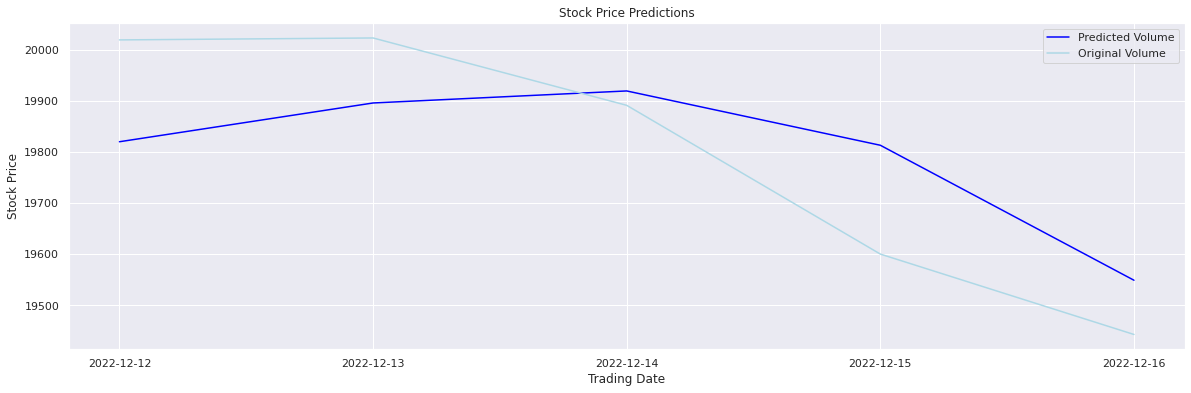

In [23]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), data.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

1/1 [==============================] - 0s 18ms/step


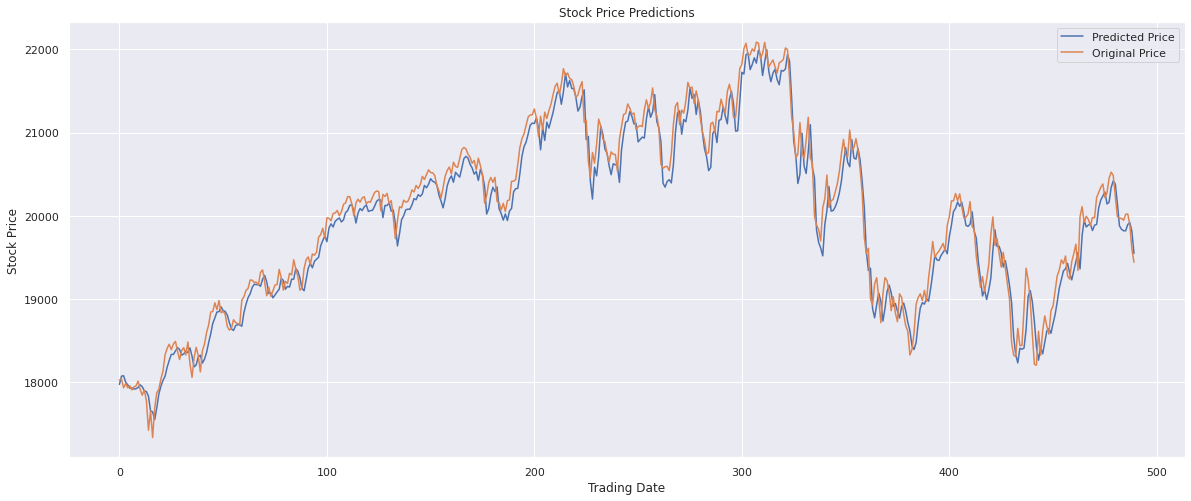

In [24]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
# plotting the full data
plt.plot(FullDataPredictions, label = 'Predicted Price')
plt.plot(FullDataOrig , label = 'Original Price')
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

#### 4.1 Pass the last 10 day's prices to predict the next days

Test the model to predict the next day's (16-Dec-2022) from the past 10 days values.

In [25]:
# Last 10 days prices
Last10Days=np.array([20485.699219, 20242.300781, 19990.199219, 19973.199219, 19969.199219,
            19947.099609, 20019.699219, 20023.500000,19891.699219, 19600.599609])
output=pd.DataFrame(columns=['Actual','Predicted'])
output['Actual']=Last10Days
# Normalizing the data 
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because the same was selected for training the model
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

1/1 [==============================] - 0s 17ms/step


array([[19549.418]], dtype=float32)

In [ ]:
#Save output to csv file
predictedPrice=[]
predictedPrice.append(predicted_Price)
for i in range(1,10):
  predictedPrice.append(" ")
output['Predicted']=predictedPrice
output.to_csv('One_Day_Prediction.csv')


* Note : Actual Close value on 16-Dec-2022 was 19,443.30	
Source : [Website](https://ca.finance.yahoo.com/quote/%5EGSPTSE/history/) There is a 1.23% difference

### 2. Multi - step Prediction (Predict for next 5 days) 

The implementation in Section 1. predicted one step value , however, this can be modified with some lines of code to forecast prices for next 5 days.

#### 2.1 Loading the last 10 days data

In [45]:
# Considering the Full Data again , extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])

# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[20242.300781]
 [19990.199219]
 [19973.199219]
 [19969.199219]
 [19947.099609]
 [20019.699219]
 [20023.5     ]
 [19891.699219]
 [19600.599609]
 [19443.300781]]
Scaled Prices
[0.61161662 0.55854483 0.55496603 0.55412396 0.54947161 0.5647551
 0.56555523 0.53780886 0.4765273  0.44341315]


#### 2.2 Split data for train and test

In [46]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(485, 10, 1)
### Output Data Shape ###
(485, 5)


#### 2.3. Predict for next 5 days choosen as Test data

In [47]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)

print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(480, 10, 1)
(480, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


In [48]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [49]:
# LSTM Model
regressor = Sequential()
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
regressor.add(Dense(units = FutureTimeSteps))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100,callbacks=[early_stopping])


Epoch 1/100
92/96 [===========================>..] - ETA: 0s - loss: 0.3288

96/96 [==============================] - 3s 9ms/step - loss: 0.3261
Epoch 2/100
95/96 [============================>.] - ETA: 0s - loss: 0.2437

96/96 [==============================] - 1s 9ms/step - loss: 0.2426
Epoch 3/100
90/96 [===========================>..] - ETA: 0s - loss: 0.1813

96/96 [==============================] - 1s 9ms/step - loss: 0.1800
Epoch 4/100
93/96 [============================>.] - ETA: 0s - loss: 0.1359

96/96 [==============================] - 1s 9ms/step - loss: 0.1348
Epoch 5/100
96/96 [==============================] - ETA: 0s - loss: 0.1035

96/96 [==============================] - 1s 9ms/step - loss: 0.1035
Epoch 6/100
93/96 [============================>.] - ETA: 0s - loss: 0.0831

96/96 [==============================] - 1s 8ms/step - loss: 0.0827
Epoch 7/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0689

96/96 [==============================] - 1s 9ms/step - loss: 0.0694
Epoch 8/100
95/96 [============================>.] - ETA: 0s - loss: 0.0617

96/96 [==============================] - 2s 18ms/step - loss: 0.0614
Epoch 9/100
95/96 [============================>.] - ETA: 0s - loss: 0.0572

96/96 [==============================] - 1s 15ms/step - loss: 0.0568
Epoch 10/100
93/96 [============================>.] - ETA: 0s - loss: 0.0540

96/96 [==============================] - 1s 9ms/step - loss: 0.0543
Epoch 11/100
95/96 [============================>.] - ETA: 0s - loss: 0.0528

96/96 [==============================] - 1s 8ms/step - loss: 0.0530
Epoch 12/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0525

96/96 [==============================] - 1s 9ms/step - loss: 0.0524
Epoch 13/100
96/96 [==============================] - ETA: 0s - loss: 0.0521

96/96 [==============================] - 1s 8ms/step - loss: 0.0521
Epoch 14/100
94/96 [============================>.] - ETA: 0s - loss: 0.0524

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 15/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 16/100
95/96 [============================>.] - ETA: 0s - loss: 0.0522

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 17/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0527

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 18/100
94/96 [============================>.] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 19/100
96/96 [==============================] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 14ms/step - loss: 0.0518
Epoch 20/100
95/96 [============================>.] - ETA: 0s - loss: 0.0517

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 21/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0515

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 22/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0513

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 23/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0521

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 24/100
93/96 [============================>.] - ETA: 0s - loss: 0.0514

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 25/100
94/96 [============================>.] - ETA: 0s - loss: 0.0517

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 26/100
96/96 [==============================] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 27/100
96/96 [==============================] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 28/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0528

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 29/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0524

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 30/100
93/96 [============================>.] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 8ms/step - loss: 0.0518
Epoch 31/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0516

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 32/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 33/100
94/96 [============================>.] - ETA: 0s - loss: 0.0515

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 34/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0516

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 35/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 36/100
95/96 [============================>.] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 37/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0516

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 38/100
95/96 [============================>.] - ETA: 0s - loss: 0.0522

96/96 [==============================] - 1s 8ms/step - loss: 0.0519
Epoch 39/100
94/96 [============================>.] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 40/100
93/96 [============================>.] - ETA: 0s - loss: 0.0522

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 41/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0517

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 42/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 43/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 44/100
95/96 [============================>.] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 45/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0513

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 46/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 8ms/step - loss: 0.0519
Epoch 47/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0505

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 48/100
95/96 [============================>.] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 49/100
95/96 [============================>.] - ETA: 0s - loss: 0.0521

96/96 [==============================] - 1s 8ms/step - loss: 0.0518
Epoch 50/100
94/96 [============================>.] - ETA: 0s - loss: 0.0522

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 51/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0521

96/96 [==============================] - 1s 8ms/step - loss: 0.0518
Epoch 52/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 53/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0520

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 54/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 55/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 8ms/step - loss: 0.0519
Epoch 56/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 57/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 58/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0521

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 59/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0523

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 60/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 61/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0522

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 62/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0516

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 63/100
95/96 [============================>.] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 64/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 8ms/step - loss: 0.0519
Epoch 65/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0524

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 66/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0528

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 67/100
96/96 [==============================] - ETA: 0s - loss: 0.0520

96/96 [==============================] - 1s 9ms/step - loss: 0.0520
Epoch 68/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 69/100
95/96 [============================>.] - ETA: 0s - loss: 0.0522

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 70/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 71/100
94/96 [============================>.] - ETA: 0s - loss: 0.0522

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 72/100
95/96 [============================>.] - ETA: 0s - loss: 0.0521

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 73/100
93/96 [============================>.] - ETA: 0s - loss: 0.0526

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 74/100
95/96 [============================>.] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 10ms/step - loss: 0.0519
Epoch 75/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 76/100
95/96 [============================>.] - ETA: 0s - loss: 0.0506

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 77/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0515

96/96 [==============================] - 1s 8ms/step - loss: 0.0519
Epoch 78/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 79/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 80/100
93/96 [============================>.] - ETA: 0s - loss: 0.0513

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 81/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 82/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0520

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 83/100
94/96 [============================>.] - ETA: 0s - loss: 0.0524

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 84/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0524

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 85/100
93/96 [============================>.] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 86/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0517

96/96 [==============================] - 1s 10ms/step - loss: 0.0518
Epoch 87/100
93/96 [============================>.] - ETA: 0s - loss: 0.0517

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 88/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 89/100
93/96 [============================>.] - ETA: 0s - loss: 0.0527

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 90/100
95/96 [============================>.] - ETA: 0s - loss: 0.0520

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 91/100
94/96 [============================>.] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 92/100
91/96 [===========================>..] - ETA: 0s - loss: 0.0521

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 93/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 94/100
94/96 [============================>.] - ETA: 0s - loss: 0.0517

96/96 [==============================] - 1s 10ms/step - loss: 0.0519
Epoch 95/100
96/96 [==============================] - ETA: 0s - loss: 0.0519

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 96/100
95/96 [============================>.] - ETA: 0s - loss: 0.0516

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 97/100
95/96 [============================>.] - ETA: 0s - loss: 0.0523

96/96 [==============================] - 1s 10ms/step - loss: 0.0519
Epoch 98/100
96/96 [==============================] - ETA: 0s - loss: 0.0518

96/96 [==============================] - 1s 9ms/step - loss: 0.0518
Epoch 99/100
95/96 [============================>.] - ETA: 0s - loss: 0.0512

96/96 [==============================] - 1s 9ms/step - loss: 0.0519
Epoch 100/100
93/96 [============================>.] - ETA: 0s - loss: 0.0523

96/96 [==============================] - 1s 9ms/step - loss: 0.0518


In [50]:
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 10)            480       
                                                                 
 lstm_21 (LSTM)              (None, 10, 5)             320       
                                                                 
 lstm_22 (LSTM)              (None, 5)                 220       
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
Total params: 1,050
Trainable params: 1,050
Non-trainable params: 0
_________________________________________________________________


#### 2.4 Make Predictions

In [51]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

1/1 [==============================] - 0s 483ms/step
#### Predicted Prices ####
[[20027.254 20032.656 20035.664 20041.34  20045.373]
 [20027.254 20032.656 20035.664 20041.34  20045.373]
 [20027.254 20032.656 20035.664 20041.34  20045.373]
 [20027.254 20032.656 20035.664 20041.34  20045.373]
 [20027.254 20032.656 20035.664 20041.34  20045.373]]

#### Original Prices ####
[[20242.300781 19990.199219 19973.199219 19969.199219 19947.099609]
 [19990.199219 19973.199219 19969.199219 19947.099609 20019.699219]
 [19973.199219 19969.199219 19947.099609 20019.699219 20023.5     ]
 [19969.199219 19947.099609 20019.699219 20023.5      19891.699219]
 [19947.099609 20019.699219 20023.5      19891.699219 19600.599609]]


* Note : Each row represents the original prices and the predicted prices.

#### 2.5 Graphs for depicting the actual and predicted on test data

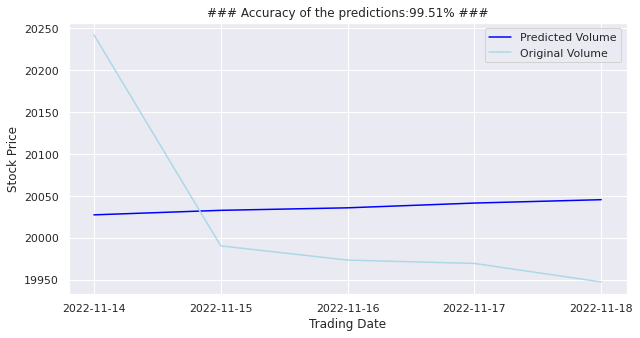

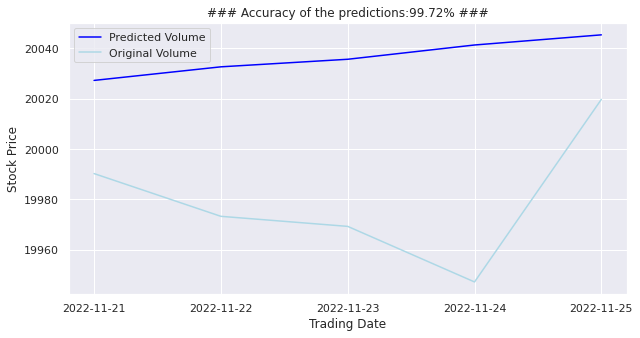

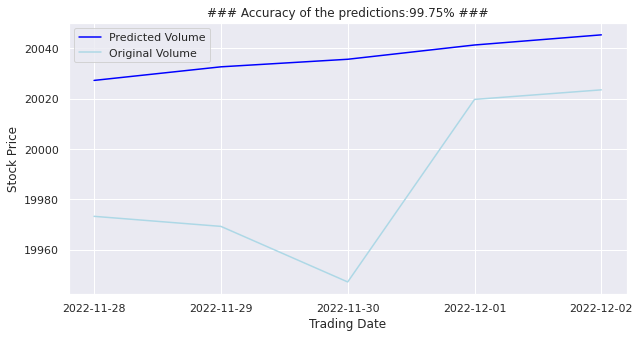

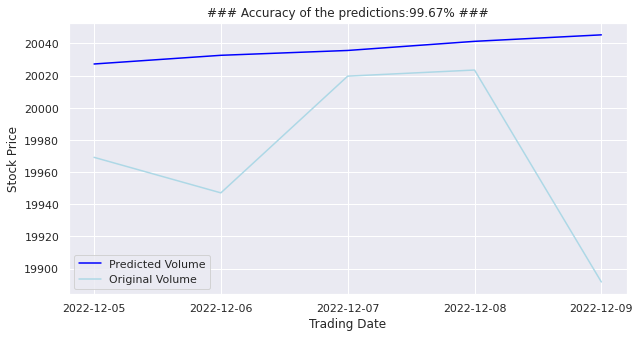

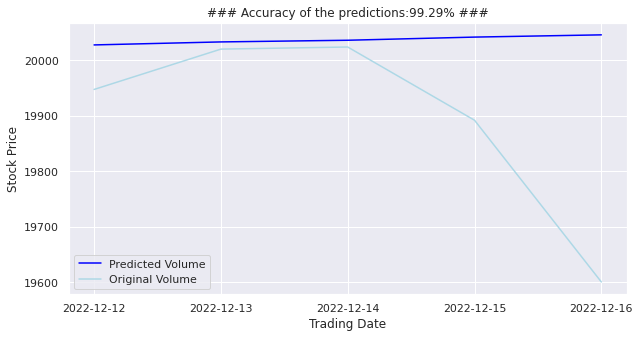

In [52]:
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')

    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=data.shape[0]

    plt.xticks(range(FutureTimeSteps), data.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Date'])
    plt.ylabel('Stock Price')

    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    plt.show()

#### 2.6 Forecasting values

In [36]:
# Making predictions on test data
Last10DaysPrices=np.array([19368.70,19184.50,19002.70,18481.00,18327.00,18307.90,18648.90,18441.80,18444.20,18881.20	])
output=pd.DataFrame(columns=['Original','Predicted'])
output['Original']=Last10DaysPrices
# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
X_test=DataScaler.transform(Last10DaysPrices)
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
Next5DaysPrice = regressor.predict(X_test)
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

1/1 [==============================] - 0s 21ms/step


array([[19072.924, 18985.9  , 19296.18 , 19581.633, 18717.277]],
      dtype=float32)